In [1]:
import sys
sys.path.append('../')
import subprocess
import pandas as pd                                                                           
import numpy as np                                                                            
import model_utils as mu
import matplotlib.pyplot as plt                                                               
from scipy.optimize import curve_fit
from scipy.special import expit

In [4]:
!ls ../concentration/

conc_inp_bulk.txt  result_bulk	result_droplets_cluster


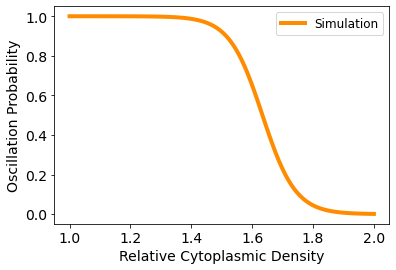

In [16]:
data_path = '../concentration/result_droplets_cluster/'
cmd = ['ls', data_path]                                                                       
proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)                                          
stdout, stderr = proc.communicate()                                                           
file_list = stdout.decode("utf-8").split()  
p_guess = [0.5, 0.3]
p_bounds = ([0, 0.1], [1, 0.5])
x = []
y = []
for d in file_list:
    data = np.load(data_path + d, allow_pickle=True)
    x.append(data['dil'].item())
    y.append(data['osc_perc'].item()/100)
# Fit sigmoidal
popt, pcov = curve_fit(mu.sigmoid, x, y, p0=p_guess)
# Plot
fig = plt.figure()                                                                            
ax = plt.gca()                                                                                
# Droplet Simulations                                                                         
xfit = np.linspace(1.0, 2.0, 100)
ax.plot(xfit, mu.sigmoid(xfit, popt[0], popt[1]), color='darkorange', 
        linewidth=4, zorder=1, label='Simulation')
ax.tick_params(labelsize=14)                                                                  
ax.lines[-1].set_label('Simulation')                                                         
ax.set_xlabel('Relative Cytoplasmic Density', fontsize=14)                                             
ax.set_ylabel('Oscillation Probability', fontsize=14)                                         
ax.legend(loc='upper right', fontsize=12)                                                     
plt.savefig('./SVGs/Osc_Prob_Conc.svg', format='svg', bbox_inches='tight')
plt.show()  

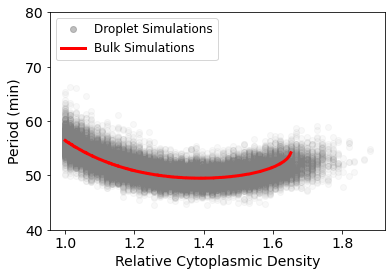

In [23]:
data_path = "../concentration/"
droplets_path = "result_droplets_cluster/"
cmd = ["ls", data_path + droplets_path]
proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
stdout, stderr = proc.communicate()
file_list = stdout.decode("utf-8").split()
# Droplet Simulations
dil, per = [], []
for f in file_list:
    data = np.load(data_path + droplets_path + f, allow_pickle=True)
    aux_periods = [d['Per'] for d in data['feature_list'] if d is not None]
    aux_amplitudes = [d['Amp'] for d in data['feature_list'] if d is not None]
    pa = list(zip(aux_periods, aux_amplitudes))
    # Filter out small amplitude solutions
    periods = [l[0] for l in pa if l[1] > 0.1]
    per += periods
    dil += (data['dil']*np.ones(len(periods))).tolist()
dil = np.array(dil)
per = np.array(per)
# Bulk Simulation
bulk_path = "result_bulk/bulk_data_conc.npz"
bulk = np.load(data_path + bulk_path, allow_pickle=True)
bulk_period = [d['Per'] if d is not None else np.NaN for d in bulk['feature_list']]
bulk_period = np.array(bulk_period)

fig = plt.figure()
ax = plt.gca()
# Droplet Simulations
ax.plot(dil, per, 'o', color='gray', alpha=0.05, 
        label='Droplet Simulations', zorder=-1, rasterized=True)
# Bulk Simulation
ax.plot(bulk['dil_list'], bulk_period, color='red', linewidth=3, 
        label='Bulk Simulations', zorder=1)
# Plot parameters
ax.tick_params(labelsize=14)
#ax.lines[-1].set_label('Experiments')
ax.set_ylim([40, 80])
ax.set_xlabel('Relative Cytoplasmic Density', fontsize=14)
ax.set_ylabel('Period (min)', fontsize=14)
leg = ax.legend(loc='upper left', fontsize=12)
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(0.5)
plt.savefig('./SVGs/Per_vs_Conc.svg', format='svg', bbox_inches='tight')
plt.show()

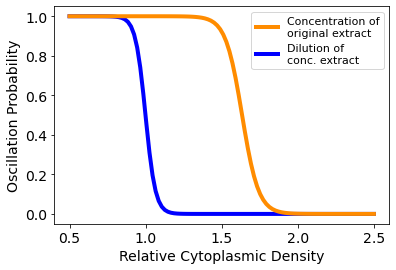

In [34]:
data_path = '../concentration/result_droplets_cluster/'
cmd = ['ls', data_path]                                                                       
proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)                                          
stdout, stderr = proc.communicate()                                                           
file_list = stdout.decode("utf-8").split()  
p_guess = [0.5, 0.3]
p_bounds = ([0, 0.1], [1, 0.5])
x = []
y = []
for d in file_list:
    data = np.load(data_path + d, allow_pickle=True)
    x.append(data['dil'].item())
    y.append(data['osc_perc'].item()/100)


file_list2 = !ls ../concentration/result_dil_of_conc 
folder2 = '../concentration/result_dil_of_conc/'
data_dict2 = {}
for f in file_list2:
    data2 = np.load(folder2 + f, allow_pickle=True)
    data_dict2[str(data2['dil'])] = data2

xdata2 = []
ydata2 = []
for dil in data_dict2:
    aux_y = np.count_nonzero(~np.isnan(data_dict2[dil]['per_list']))/100
    aux_x = float(dil)
    if aux_x > 1:
        xdata2.append(aux_x)
        ydata2.append(aux_y)

# Fit sigmoidal
xfit = np.linspace(0.5, 2.5, 100)
popt, pcov = curve_fit(mu.sigmoid, x, y, p0=p_guess)
popt2, pcov2 = curve_fit(mu.sigmoid, xdata2, ydata2, p0 = [-0.02,0.8])

# Plot
fig = plt.figure()                                                                            
ax = plt.gca()                                                                                
# Droplet Simulations                                                                         
ax.plot(xfit, mu.sigmoid(xfit, popt[0], popt[1]), color='darkorange', 
        linewidth=4, zorder=1, label='Concentration of\noriginal extract')
ax.plot(xfit, mu.sigmoid(xfit,popt2[0],popt2[1]), linewidth=4, 
        color = 'blue', zorder=0, label='Dilution of\nconc. extract')

ax.tick_params(labelsize=14)                                                                  
ax.set_xlabel('Relative Cytoplasmic Density', fontsize=14)                                             
ax.set_ylabel('Oscillation Probability', fontsize=14)                                         
ax.legend(loc='upper right', fontsize=11)                                                     
plt.savefig('./SVGs/Hysteresis.svg', format='svg', bbox_inches='tight')
plt.show()  